In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# the first column can be used as index of the dataframe
fifa19 = pd.read_csv("./fifa19/data.csv", index_col=0)


In [2]:
attributes = ['Acceleration', 'Aggression', 'Agility', 'Balance', 'BallControl',
       'Body Type','CAM', 'CB', 'CDM', 'CF', 'CM', 'Composure', 'Crossing', 'Curve', 'Dribbling', 'FKAccuracy',
       'Finishing', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning',
       'GKReflexes', 'HeadingAccuracy', 'Interceptions','Jumping','LAM',
       'LB', 'LCB', 'LCM', 'LDM', 'LF', 'LM', 'LS', 'LW', 'LWB', 'LongPassing', 'LongShots', 'Marking', 'Penalties',
       'Positioning', 'RAM', 'RB', 'RCB', 'RCM', 'RDM', 'RF',
       'RM', 'RS', 'RW', 'RWB', 'Reactions', 'ST', 'ShortPassing', 'ShotPower', 'Skill Moves', 'SlidingTackle',
       'SprintSpeed', 'Stamina', 'StandingTackle', 'Strength', 'Vision', 'Volleys']

In [3]:
from utils import change_bodyShape

fifa19["Body Type"] = fifa19["Body Type"].apply(change_bodyShape)   

In [4]:
def change_skill_move(x):
    return x * 20

fifa19["Skill Moves"] = fifa19["Skill Moves"].apply(change_skill_move)

After printing the columns, I found that some of them contain add or subtract operations, not only from 23 up to 35, even column 66 has this problem. We should fix them to maintain a fixed data type.

In [5]:
from utils import fix_value

for column in attributes:
    fifa19[column] = fifa19[column].apply(fix_value)


Now all calculations are completed.   
In this dataset, NaN or null values cannot be omitted because positions like GK do not have some attributes as other positions have, which means citerion of GK is partly different from others.  
In the next step, wages and values are converted into float type instead of object type. (€95.5M will be 95500000, €4.1K will be 4100, €0 will be 0.)

In [6]:
from utils import convert_value

fifa19['Value'] = fifa19['Value'].apply(convert_value)
fifa19['Wage'] = fifa19['Wage'].apply(convert_value)
fifa19['Release Clause'] = fifa19['Release Clause'].apply(convert_value)


Some players have no wage and values, because they are called Free Agents.   
For further analysis, I will store them to another csv file.

In [7]:
fifa19_has_club = fifa19.dropna(subset = ['Club'])
fifa19_no_wage = fifa19[(fifa19['Wage'] == 0) & (fifa19['Value'] == 0)]
print("Players with no Clubs: ", len(fifa19) - len(fifa19_has_club))
print("Players with no Clubs:", len(fifa19_no_wage))

Players with no Clubs:  233
Players with no Clubs: 233


The above cell shows that players who do not affiliated to a club is consistent with players owning no wage and having no player value in the transfer market from now on.  
So I can simply store those players with a single crietria. Concretely, I choose the column "Wage" and "Value" to classify Free Agents and other players.  
What's more, Chinese players are extracted for analysis which will be shown in future cells.

In [8]:
fifa19_no_wage.to_csv("free_agents.csv")
chinese_players = fifa19[(fifa19['Nationality'] == "China PR")]
chinese_players.to_csv("Chinese_players.csv")

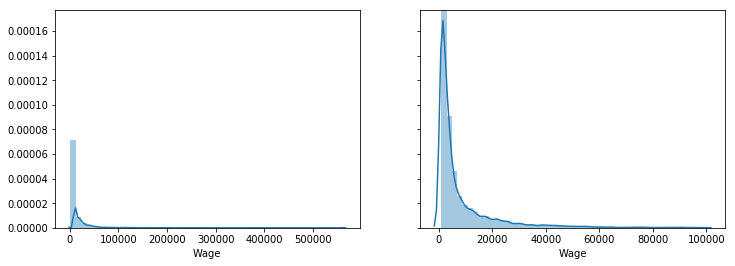

In [9]:
fifa19 = fifa19_has_club
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4), sharey=True) 
wages = fifa19['Wage']
sns.distplot(fifa19['Wage'], kde=True, rug=False, ax=ax1);
sns.distplot(wages[wages < 100000], kde=True, rug=False, ax=ax2);

In [10]:
length = len(fifa19)
wages = fifa19['Wage']
highest_payed = wages.sort_values(ascending=False)[0:5].index
# lowest payed players ignoring 0
lowest_payed = wages.sort_values(ascending=True)[0:5].index
print("highest paid\n" ,fifa19[['Name','Wage']].loc[highest_payed])
print("lowest paid\n" ,fifa19[['Name','Wage']].loc[lowest_payed])

highest paid
                 Name      Wage
0           L. Messi  565000.0
7          L. Suárez  455000.0
6          L. Modrić  420000.0
1  Cristiano Ronaldo  405000.0
8       Sergio Ramos  380000.0
lowest paid
                Name    Wage
13700   O. Sangante  1000.0
10384      R. Scheu  1000.0
14437  Ryu Jae Moon  1000.0
14439    I. Franjic  1000.0
14440       M. Mara  1000.0


#### Analytic Question 1: Which clubs have highly skilled players on average and what is the distrubiton of ages in those clubs?

c:\programdata\anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


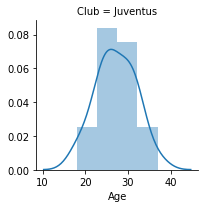

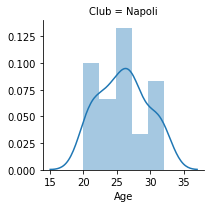

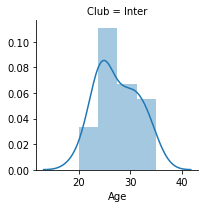

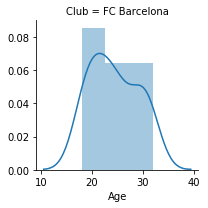

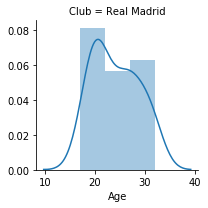

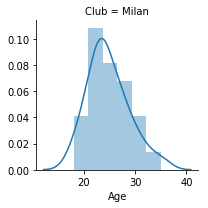

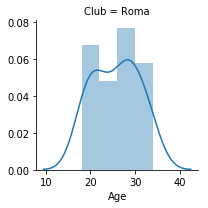

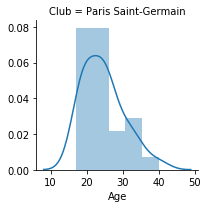

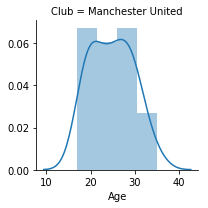

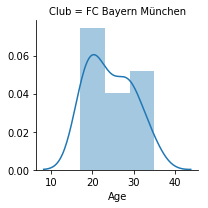

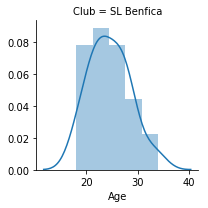

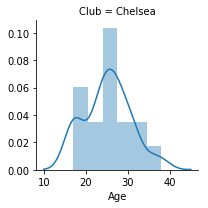

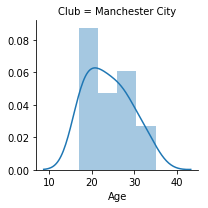

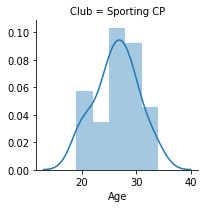

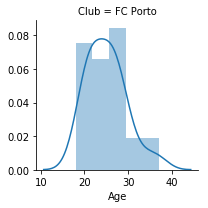

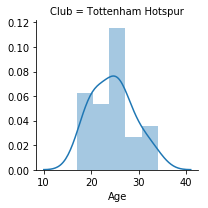

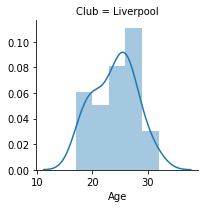

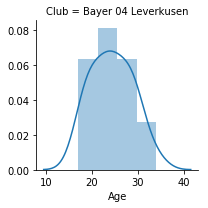

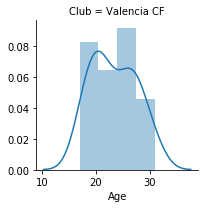

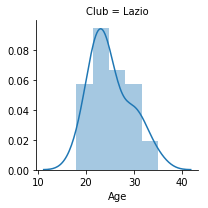

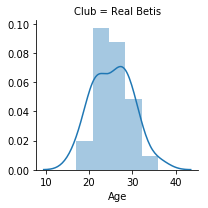

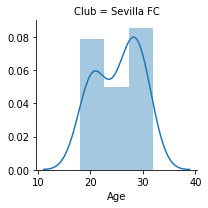

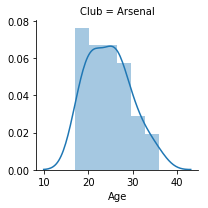

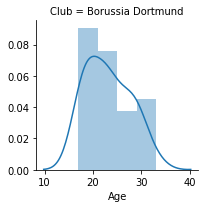

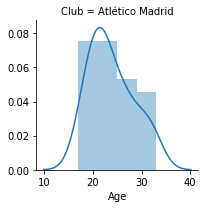

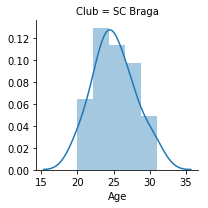

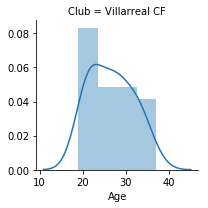

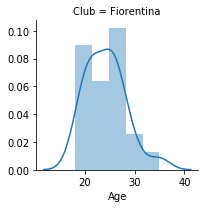

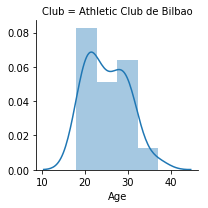

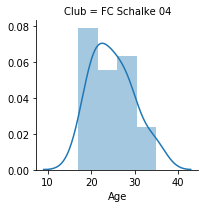

In [11]:
# group the data by football club
data_group_by_club = fifa19.groupby('Club')
# find the mean of each attribute and select the Overall column
clubs_average_overall = data_group_by_club['Overall'].mean()
# sort the average overall in descending order and slice the top 30
top_clubs_top_k = clubs_average_overall.sort_values(ascending = False)
g = {}
for rank in range(30):
    club = top_clubs_top_k.index[rank]
    # filter the big dataframe to include only players from top clubs
    fifa19_top = fifa19.loc[fifa19['Club'].isin([club])]
    # create seaborn FacetGrid object
    g[club.index] = sns.FacetGrid(fifa19_top, col='Club')
    # In each column plot the age distrubtion of a club
    g[club.index].map(sns.distplot, "Age")
plt.show()

c:\programdata\anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


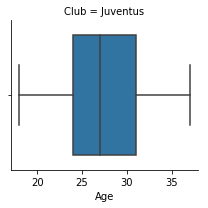

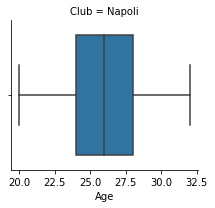

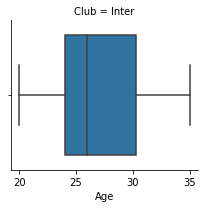

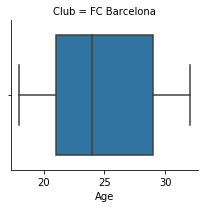

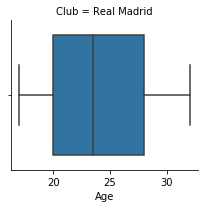

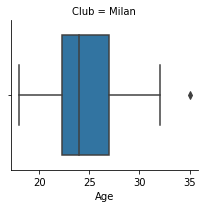

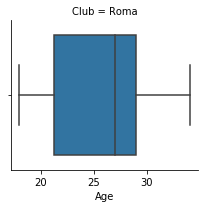

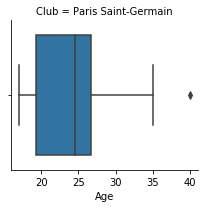

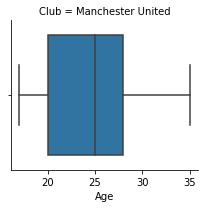

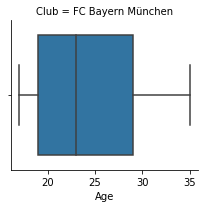

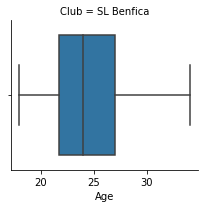

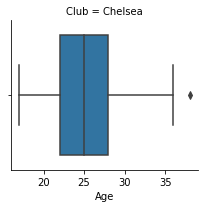

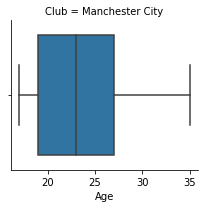

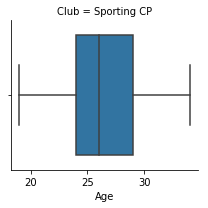

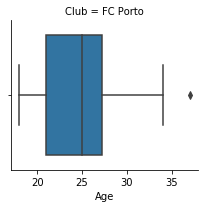

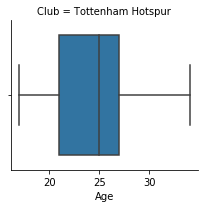

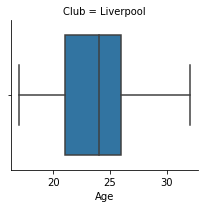

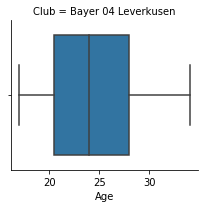

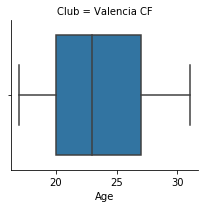

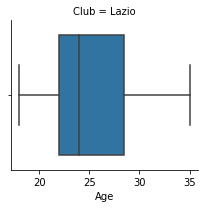

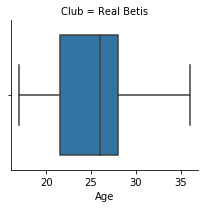

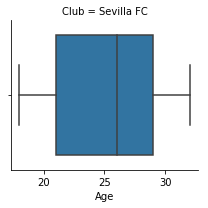

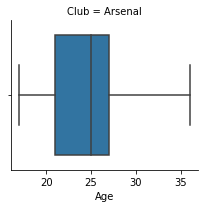

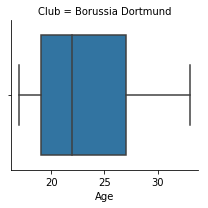

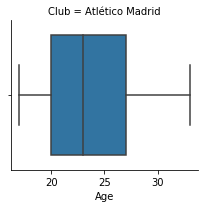

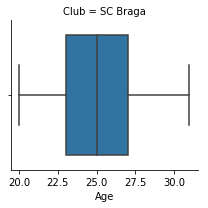

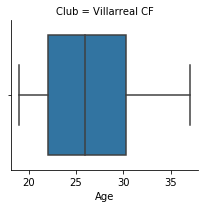

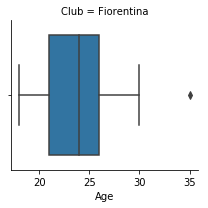

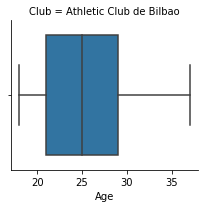

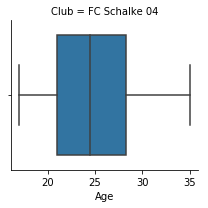

In [12]:
for rank in range(30):
    club = top_clubs_top_k.index[rank]
    fifa19_top = fifa19.loc[fifa19['Club'].isin([club])]
    g = sns.FacetGrid(fifa19_top, col='Club')
    g.map(sns.boxplot, "Age", order='')
plt.show()

#### Analytic Question 2: Find underrated young players who may be in wrong positions and have potent to play better in other positions.

In [14]:
from utils import find_GK

fifa19 = fifa19.drop(list(fifa19.loc[fifa19["Position"].isna()].index))
fifa19['GK'] = fifa19["Position"].apply(find_GK)
fifa19_noGK = fifa19[fifa19["GK"] == False]
del fifa19_noGK["GK"]

Import encoding and decoding function which is related to transforming "Position" into sparse numbers.  
What's more, transformimg "Position" labels into one-hot code for softmax activation at the end of the neural network.

In [15]:
from utils import decode_position, encode_position
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder().fit(np.arange(0,26).reshape(-1,1))

young = fifa19_noGK[fifa19_noGK['Age'] <= 23]
veteran = fifa19_noGK[fifa19_noGK['Age'] > 23]

attributes = ['Acceleration', 'Aggression', 'Agility', 'Balance', 'BallControl',
       'Body Type', 'Composure', 'Crossing', 'Curve', 'Dribbling', 'FKAccuracy',
       'Finishing', 'HeadingAccuracy', 'Interceptions','Jumping', 'LongPassing', 'LongShots', 'Marking', 'Penalties',
       'Positioning', 'Reactions', 'ShortPassing', 'ShotPower', 'Skill Moves', 'SlidingTackle',
       'SprintSpeed', 'Stamina', 'StandingTackle', 'Strength', 'Vision', 'Volleys']

x = veteran[attributes].values
x_youth = young[attributes].values
y = veteran["Position"].values
y = encode_position(y)
y = onehot_encoder.transform(y.reshape(-1, 1))


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

scaler = StandardScaler()
scaler.fit(x) #Fit to veteran data
x_scaled = scaler.transform(x)
x_youth_scaled = scaler.transform(x_youth)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.25)

c:\programdata\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\programdata\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:
x_train.shape

(7160, 31)

In [18]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras import backend as K
from keras.regularizers import l2
from keras.models import Model
from sklearn.metrics import accuracy_score
from keras import metrics

Using TensorFlow backend.


In [19]:
def top_3_accuracy(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

def fifa_model(input_shape):
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_dim=input_shape, kernel_initializer='TruncatedNormal',kernel_regularizer=l2(1e-4)))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=64, activation='relu', kernel_initializer='TruncatedNormal',kernel_regularizer=l2(1e-4)))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=26, activation='softmax', kernel_initializer='TruncatedNormal',kernel_regularizer=l2(1e-4)))
    return model

model = fifa_model(x_train.shape[1])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[top_3_accuracy])
model.fit(x_train, y_train, batch_size=32, epochs=100)



Epoch 1/100
7160/7160 [==============================] - 1s 82us/step - loss: 2.2410 - top_3_accuracy: 0.6013
Epoch 2/100
7160/7160 [==============================] - 0s 45us/step - loss: 1.7289 - top_3_accuracy: 0.7497
Epoch 3/100
7160/7160 [==============================] - 0s 45us/step - loss: 1.6490 - top_3_accuracy: 0.7655
Epoch 4/100
7160/7160 [==============================] - 0s 43us/step - loss: 1.6127 - top_3_accuracy: 0.7771
Epoch 5/100
7160/7160 [==============================] - 0s 43us/step - loss: 1.5992 - top_3_accuracy: 0.7795
Epoch 6/100
7160/7160 [==============================] - 0s 45us/step - loss: 1.5872 - top_3_accuracy: 0.7809
Epoch 7/100
7160/7160 [==============================] - 0s 43us/step - loss: 1.5823 - top_3_accuracy: 0.7823
Epoch 8/100
7160/7160 [==============================] - 0s 43us/step - loss: 1.5730 - top_3_accuracy: 0.7870
Epoch 9/100
7160/7160 [==============================] - 0s 43us/step - loss: 1.5649 - top_3_accuracy: 0.7919
Epoch 10/1

In [20]:
score, acc = model.evaluate(x_test, y_test, batch_size=64)
print(acc)

2387/2387 [==============================] - 0s 28us/step
0.7980728946473242


In [21]:
y_predict = model.predict(x_youth_scaled)

In [22]:
sorted_position = y_predict.argsort(axis=1)[:, -3:]
preferred_position = np.zeros(sorted_position.shape, dtype=object)
for i in range(sorted_position.shape[0]):
    preferred_position[i] = decode_position(sorted_position[i])
position_top1 = preferred_position[:, -1]
position_top2 = preferred_position[:, -2]
position_top3 = preferred_position[:, -3]


In [23]:
young_original_position = young["Position"].values
suitable = np.zeros(young_original_position.shape)
for i in range(preferred_position.shape[0]):
    if young_original_position[i] in list(preferred_position[i]):
        suitable[i] = 1
    else:
        suitable[i] = 0

In [24]:
pd.options.mode.chained_assignment = None  # default='warn'
young["preferred position 1st"] = position_top1
young["preferred position 2nd"] = position_top2
young["preferred position 3rd"] = position_top3
young["suitable or not"] = suitable
young["suitable or not"].value_counts()

1.0    4884
0.0    1150
Name: suitable or not, dtype: int64

In [25]:
not_suitable = young[young["suitable or not"]==0]
show_not_suitable = not_suitable[not_suitable["Value"] >= 10000000]
show_list = ["Name", "Value", "Position", "preferred position 1st", "preferred position 2nd", "preferred position 3rd"]
show_not_suitable[show_list]

,Name,Value,Position,preferred position 1st,preferred position 2nd,preferred position 3rd
56,L. Sané,62500000.0,LW,RM,LM,RW
80,S. Milinković-Savić,50500000.0,LW,RM,LM,RW
158,O. Dembélé,40000000.0,RW,RM,LM,CAM
163,P. Kimpembe,30500000.0,CM,CAM,LCM,RCM
172,Bruno Fernandes,34000000.0,LW,ST,RS,RM
174,A. Martial,35500000.0,LDM,CM,RCM,LCM
175,Samu Castillejo,34000000.0,LCM,CM,RCM,RM
177,L. Goretzka,34000000.0,RAM,CM,CAM,LCM
229,L. Bailey,31500000.0,RW,CAM,LM,RM
235,C. Lenglet,26000000.0,RCM,CDM,RDM,LDM


It is clear to see that about one-fifth of young players may not in their most suitable positions, so they may be potential to perform better if they can try a new position as predicted.

#### Analytic Question 3: How does the performance attributes vary among forwards, midfielders and defenders?

Text(0.5,1,'Correlation Between Performance Attributes')

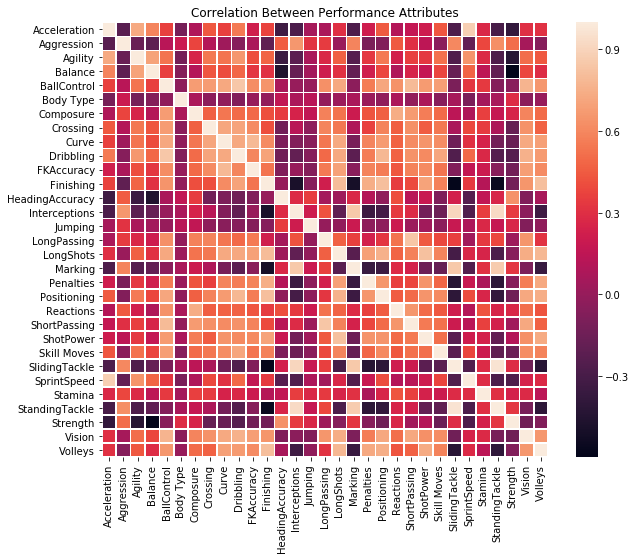

In [26]:
fifa19_performance = fifa19_noGK[attributes]
corr = fifa19_performance.corr()
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(corr, linewidths=.5, ax=ax)
ax.set_title("Correlation Between Performance Attributes")

In [27]:
def wipe_same_name(data):
    for column in data.columns:
        data[column][column] = 0
    return data

In [28]:
corr_processed = wipe_same_name(corr)
pos_related = corr_processed.idxmax()
neg_related = corr_processed.idxmin()
pos_related

Acceleration           SprintSpeed
Aggression           Interceptions
Agility               Acceleration
Balance                    Agility
BallControl              Dribbling
Body Type                 Strength
Composure                Reactions
Crossing                     Curve
Curve                   FKAccuracy
Dribbling              BallControl
FKAccuracy                   Curve
Finishing              Positioning
HeadingAccuracy           Strength
Interceptions       StandingTackle
Jumping            HeadingAccuracy
LongPassing           ShortPassing
LongShots                ShotPower
Marking             StandingTackle
Penalties                Finishing
Positioning              Finishing
Reactions                Composure
ShortPassing           LongPassing
ShotPower                LongShots
Skill Moves              Dribbling
SlidingTackle       StandingTackle
SprintSpeed           Acceleration
Stamina                  Reactions
StandingTackle       SlidingTackle
Strength           H

In [29]:
finishing = corr['Finishing'].sort_values(ascending = False)
finishing_top_correlated = finishing.head(5)
print("Highest Positive Correlation to Finishing\n", finishing_top_correlated)

Highest Positive Correlation to Finishing
 Positioning    0.818461
Volleys        0.813961
LongShots      0.802331
Penalties      0.746570
Dribbling      0.704695
Name: Finishing, dtype: float64


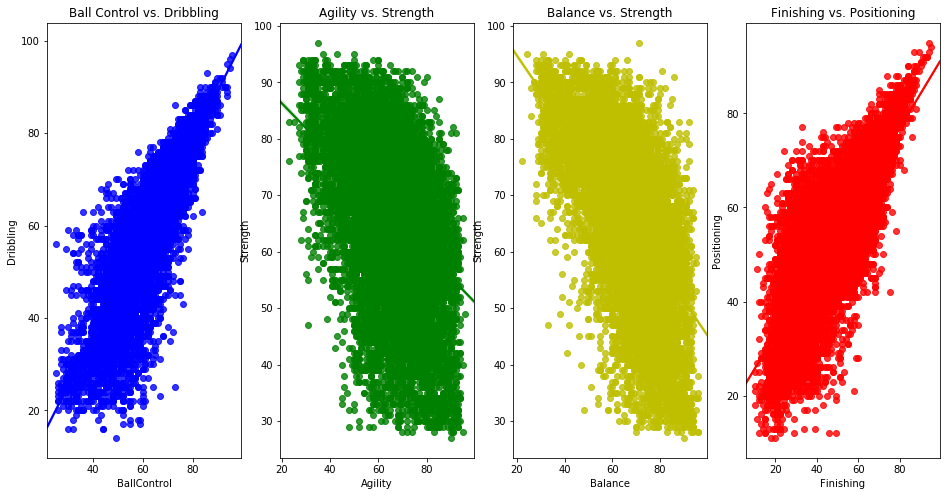

In [30]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(1,4, figsize=(16,8)) 

ax1.set_title("Ball Control vs. Dribbling")
ax2.set_title("Agility vs. Strength")
ax3.set_title("Balance vs. Strength")
ax4.set_title("Finishing vs. Positioning")

sns.regplot(x="BallControl", y="Dribbling", ax = ax1, data=fifa19_noGK, color='b')
sns.regplot(x="Agility", y="Strength", ax = ax2, data=fifa19_noGK, color="g")
sns.regplot(x="Balance", y="Strength", ax = ax3, data=fifa19_noGK, color="y")
sns.regplot(x="Finishing", y="Positioning", ax = ax4, data=fifa19_noGK, color="r")

In [31]:
forward = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW']
# All the midfield positions end with an M
midfield = ['LAM', 'CAM', 'RAM', 'LM', 'LCM', 'RCM','CM', 'RM', 'LDM', 'CDM', 'RDM']
defense = ['LB', 'LWB', 'LCB', 'CB', 'RCB', 'RB', 'RWB']


Forward, midfielder and defenser are classified so as to analysis attritubes of players more precisely. Therefore, we add a column for future convinence.

In [32]:
from utils import position_check

fifa19_noGK["Pref_Pos_Encoded"] = fifa19_noGK['Position'].apply(position_check)
fifa19_noGK['Pref_Pos_String'] = fifa19_noGK['Pref_Pos_Encoded'].apply(lambda x: "Defense" if x == 4 else ("Midfield" if x == 2 else "Attack"))


We should remove GK attributes from other positions' attributes because they don't even need those skills.

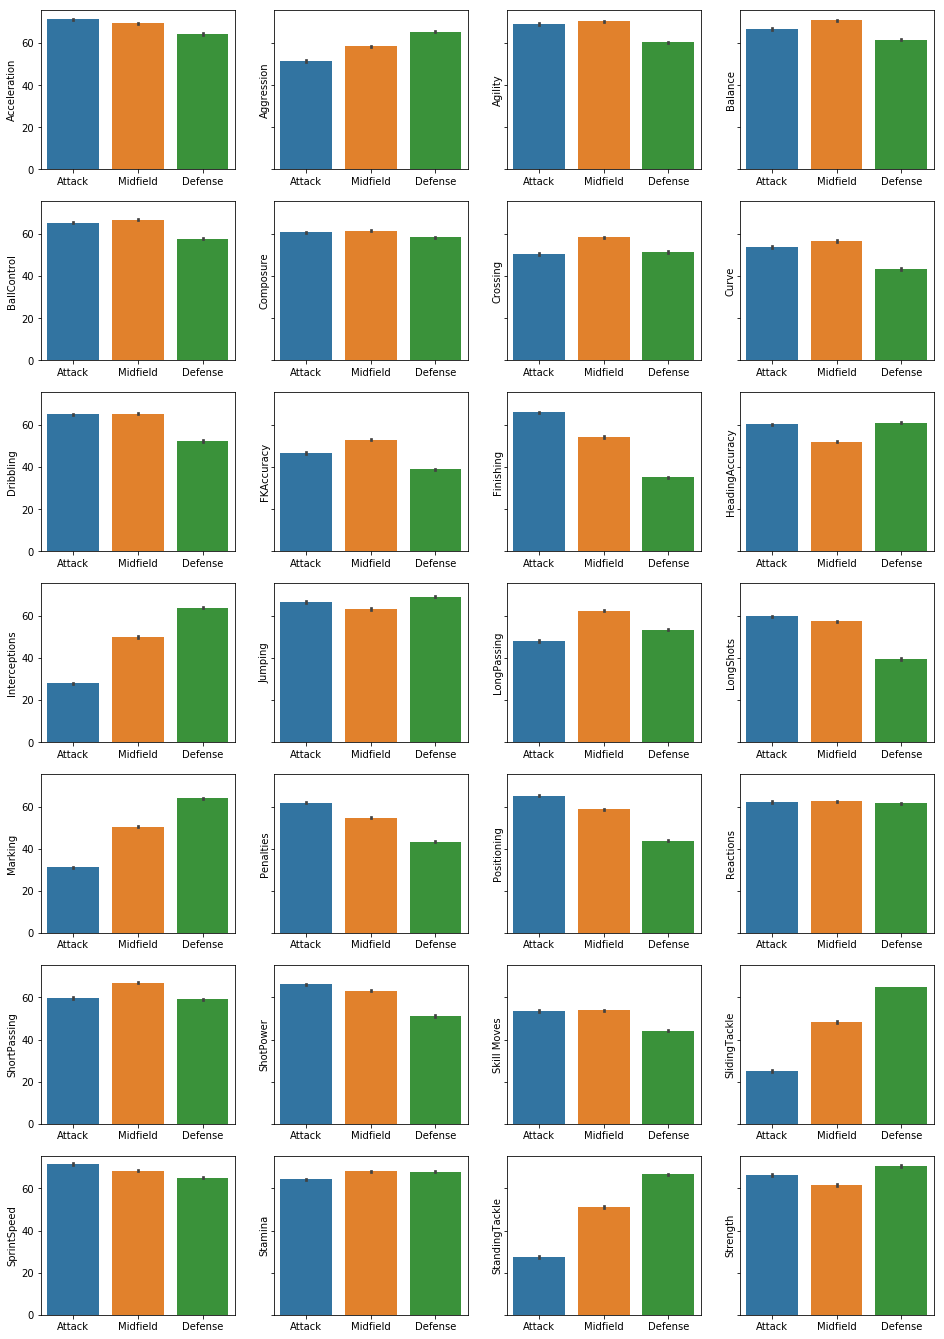

In [33]:
fig, axes= plt.subplots(7, 4, figsize=(16,24),sharey = True) 
# select some attributes
attribute_normal = ['Acceleration', 'Aggression', 'Agility', 'Balance', 'BallControl', 'Composure', 'Crossing', 'Curve', 'Dribbling', 'FKAccuracy',
       'Finishing', 'HeadingAccuracy', 'Interceptions','Jumping', 'LongPassing', 'LongShots', 'Marking', 'Penalties',
       'Positioning', 'Reactions', 'ShortPassing', 'ShotPower', 'Skill Moves', 'SlidingTackle',
       'SprintSpeed', 'Stamina', 'StandingTackle', 'Strength', 'Vision', 'Volleys']
under_study = list(attribute_normal[0:28])
# flatten the axis list
axes_list = axes.ravel()
for i, ax in enumerate(axes_list):
    ax.xaxis.label.set_visible(False)
    ax.grid = False
    sns.barplot(x="Pref_Pos_String", y=under_study[i], data=fifa19_noGK, ax = ax)

Now we analyze features of attackers, midifielders and defenders respectively.

In [34]:
grouped_mean = fifa19_noGK[attribute_normal+["Pref_Pos_String"]].groupby("Pref_Pos_String").mean()
grouped_mean

,Acceleration,Aggression,Agility,Balance,BallControl,Composure,Crossing,Curve,Dribbling,FKAccuracy,...,ShortPassing,ShotPower,Skill Moves,SlidingTackle,SprintSpeed,Stamina,StandingTackle,Strength,Vision,Volleys
Pref_Pos_String,,,,,,,,,,,,,,,,,,,,,
Attack,71.140012,51.408871,68.993965,66.611949,65.312613,60.652987,50.577550,53.569403,64.986723,46.354255,...,59.680748,66.224502,53.669282,25.051901,71.552806,64.303862,27.476463,66.138202,56.899819,57.621605
Defense,64.153574,65.330856,60.205060,61.521762,57.561394,58.384466,51.203999,43.372435,52.318825,38.836518,...,59.054494,51.317941,44.207360,64.975938,65.128981,67.951345,66.647558,70.626150,46.084926,35.621550
Midfield,69.356916,58.272865,70.352834,70.771580,66.689191,61.529101,58.347695,56.588813,65.203930,52.837037,...,66.905518,63.113530,53.862434,48.473621,68.457899,68.015117,51.147241,61.638549,62.500680,50.685261


##### Top features of Attackers

In [35]:
grouped_mean.loc["Attack"].sort_values(ascending = False).head(8)

SprintSpeed     71.552806
Acceleration    71.140012
Agility         68.993965
Balance         66.611949
Jumping         66.349125
ShotPower       66.224502
Strength        66.138202
Finishing       65.815027
Name: Attack, dtype: float64

##### Top features of Midfielders

In [36]:
grouped_mean.loc["Midfield"].sort_values(ascending = False).head(8)

Balance         70.771580
Agility         70.352834
Acceleration    69.356916
SprintSpeed     68.457899
Stamina         68.015117
ShortPassing    66.905518
BallControl     66.689191
Dribbling       65.203930
Name: Midfield, dtype: float64

##### Top features of Defenders

In [37]:
grouped_mean.loc["Defense"].sort_values(ascending = False).head(8)

Strength          70.626150
Jumping           69.031493
Stamina           67.951345
StandingTackle    66.647558
Aggression        65.330856
SprintSpeed       65.128981
SlidingTackle     64.975938
Acceleration      64.153574
Name: Defense, dtype: float64

If we only analyze top 1000 players, may be we can get another result! So let's begin.

In [38]:
top_players = fifa19_noGK[fifa19_noGK.columns][:1000]
top_grouped_mean = top_players[attribute_normal+["Pref_Pos_String"]].groupby("Pref_Pos_String").mean()
top_grouped_mean

,Acceleration,Aggression,Agility,Balance,BallControl,Composure,Crossing,Curve,Dribbling,FKAccuracy,...,ShortPassing,ShotPower,Skill Moves,SlidingTackle,SprintSpeed,Stamina,StandingTackle,Strength,Vision,Volleys
Pref_Pos_String,,,,,,,,,,,,,,,,,,,,,
Attack,76.846809,64.578723,76.195745,71.429787,80.327660,77.578723,66.331915,71.625532,79.089362,62.982979,...,74.553191,79.876596,71.659574,28.825532,76.417021,72.961702,33.982979,70.948936,72.093617,75.293617
Defense,68.365079,78.006349,64.622222,63.060317,71.295238,74.038095,62.339683,55.907937,64.904762,47.955556,...,73.457143,66.349206,50.793651,79.400000,71.390476,74.568254,80.539683,76.485714,58.441270,45.374603
Midfield,72.668889,68.673333,75.617778,73.662222,80.780000,77.175556,71.751111,72.055556,78.891111,66.908889,...,80.248889,75.953333,70.622222,57.402222,70.895556,77.706667,61.951111,67.366667,77.604444,65.555556


##### Top features of Attackers

In [39]:
top_grouped_mean.loc["Attack"].sort_values(ascending = False).head(8)

Positioning     81.485106
BallControl     80.327660
ShotPower       79.876596
Finishing       79.561702
Reactions       79.200000
Dribbling       79.089362
Composure       77.578723
Acceleration    76.846809
Name: Attack, dtype: float64

##### Top features of Midfielders

In [40]:
top_grouped_mean.loc["Midfield"].sort_values(ascending = False).head(8)

BallControl     80.780000
ShortPassing    80.248889
Dribbling       78.891111
Reactions       77.760000
Stamina         77.706667
Vision          77.604444
Composure       77.175556
ShotPower       75.953333
Name: Midfield, dtype: float64

##### Top features of Defenders

In [41]:
top_grouped_mean.loc["Defense"].sort_values(ascending = False).head(8)

StandingTackle    80.539683
SlidingTackle     79.400000
Interceptions     78.841270
Marking           78.152381
Aggression        78.006349
Reactions         76.892063
Strength          76.485714
Jumping           75.158730
Name: Defense, dtype: float64

It is clear that top players are excell at more technical parts.

#### Analytic Question 4: Choose the best squad of 11 players.

### Squad of best 11 players


In [42]:
def get_best_squad(df, position):
    data = df.copy()
    store = []
    for i in position:
        store.append([i,data.loc[[data[data['Position'] == i]['Overall'].idxmax()]]['Name'].to_string(index = False), data[data['Position'] == i]['Overall'].max()])
        data.drop(data[data['Position'] == i]['Overall'].idxmax(), inplace = True)
    #return store
    return pd.DataFrame(np.array(store).reshape(11,3), columns = ['Position', 'Player', 'Overall']).to_string(index = False)


In [43]:
squad_433 = ['GK', 'LB', 'CB', 'CB', 'RB', 'LM', 'CDM', 'RM', 'LW', 'ST', 'RW']
print ('4-3-3')
print(get_best_squad(fifa19, squad_433))

4-3-3
Position             Player Overall
     GK             De Gea      91
     LB            Marcelo      88
     CB          S. Umtiti      87
     CB      J. Vertonghen      87
     RB         A. Sánchez      86
     LM      P. Aubameyang      88
    CDM    Sergio Busquets      89
     RM         C. Eriksen      88
     LW  Cristiano Ronaldo      94
     ST          L. Suárez      91
     RW           L. Messi      94


In [44]:
squad_352 = ['GK', 'LWB', 'CB', 'RWB', 'LM', 'CDM', 'CAM', 'CM', 'RM', 'LW', 'RW']
print ('3-5-2')
print (get_best_squad(fifa19, squad_352))

3-5-2
Position             Player Overall
     GK             De Gea      91
    LWB         I. Marcone      79
     CB          S. Umtiti      87
    RWB          S. Haller      79
     LM      P. Aubameyang      88
    CDM    Sergio Busquets      89
    CAM          Neymar Jr      92
     CM          T. Müller      86
     RM         C. Eriksen      88
     LW  Cristiano Ronaldo      94
     RW           L. Messi      94


#### Analytic Question 5: WordCloud and Mapping analysis

(-0.5, 699.5, 399.5, -0.5)

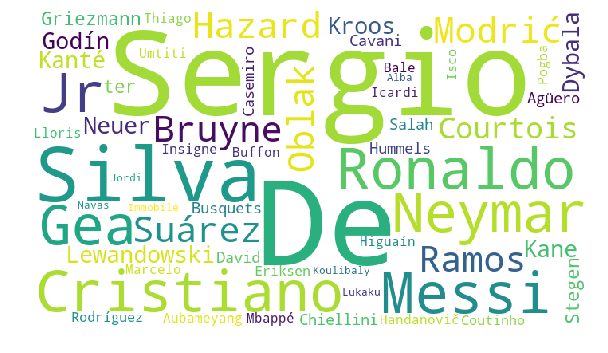

In [45]:
from wordcloud import WordCloud
#Prepare Data Frame
name_frame = fifa19["Name"][:50]

plt.subplots(figsize=(10,10))
wordcloud = WordCloud(
                   background_color='White',
                        width = 700,
                        height = 400
    ).generate(" ".join(name_frame))

plt.imshow(wordcloud)
plt.axis('off')

Some nations' name are not identical to the required names in pyechart, so we should convert some of them and do some revision.

In [46]:
from utils import extract_nations

index = 0
nation_data = fifa19["Nationality"]
nations, nation_counts = extract_nations(nation_data)
nation_value = [0] * len(nations)
for nation in nations:
    nation_value[index] = nation_counts[nation]
    index += 1


In [47]:
from pyecharts import Map

map0 = Map("Players' distribution map", width=1200, height=600)
map0.add("Players' distribution map", nations, nation_value, maptype="world", is_visualmap=True, visual_text_color='#000')
map0.render(path="./Players' distribution map.html")

#### Analytic Question 6: Player's overall rating vs. Market value

First, we try to fit the data with all players, finding the relationship between overall rating and market value.

In [48]:
overall_rating = fifa19['Overall'].values.reshape(-1,1)
market_value = fifa19["Value"].values.reshape(-1,1)/1e+06
market_value

array([[1.105e+02],
       [7.700e+01],
       [1.185e+02],
       ...,
       [1.000e-01],
       [7.000e-02],
       [7.000e-02]])

In [49]:
def plot_chart(X, y, y_pred, x_l, x_h, y_l, y_h, c):
    plt.figure(figsize = (15,10))
    plt.scatter(X, y, color=c)
    plt.plot(X, y_pred, color='blue', linewidth=3)

    plt.title('Player value (M) vs rating')
    plt.ylim(y_l,y_h)
    plt.xlim(x_l,x_h)
    plt.ylabel('Value (M)')
    plt.xlabel('Player ratings')

Text(50,105,'Goalkeeper')

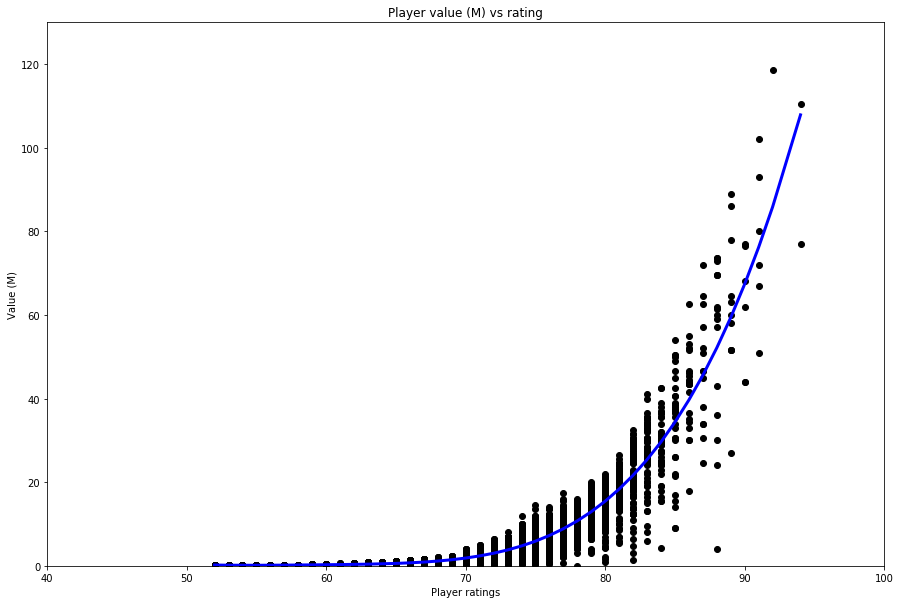

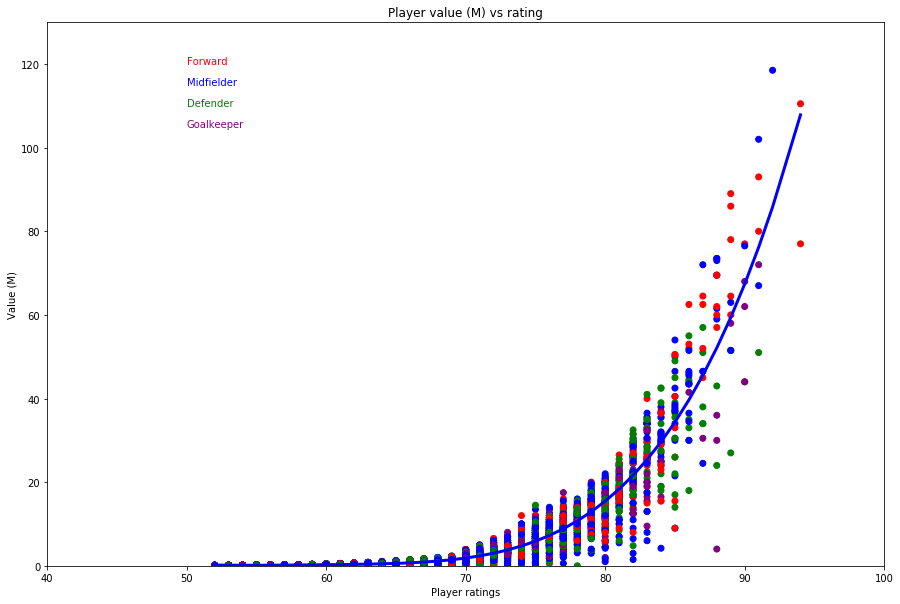

In [50]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model


poly = PolynomialFeatures(degree=4)
rating_p= poly.fit_transform(overall_rating)
poly_model = linear_model.LinearRegression().fit(rating_p, market_value)
value_pred = poly_model.predict(rating_p)

color_dict = {}
for pos in forward:
    color_dict[pos] = 'red'
for pos in midfield:
    color_dict[pos] = 'blue'
for pos in defense:
    color_dict[pos] = 'green'
color_dict['GK'] = 'purple'
c = fifa19['Position'].map(color_dict)

plot_chart(overall_rating, market_value, value_pred, 40, 100, 0, 130, 'black')

# by positions
plot_chart(overall_rating, market_value, value_pred, 40, 100, 0, 130, c)
plt.text(50, 120, 'Forward', color = 'red')
plt.text(50, 115, 'Midfielder', color = 'blue')
plt.text(50, 110, 'Defender', color = 'green')
plt.text(50, 105, 'Goalkeeper', color = 'purple')


From above, we can see that those significantly overpriced players (way above the blue curve) are mostly forward and midfielder players, while those underpriced players are mostly goalkeeps and defenders.

#### Analytic Question 7: Chinese players' wage analysis

First, we train the model with data without Chinese players.

In [51]:
from utils import find_CPR

fifa19_noGK['CPR'] = fifa19["Nationality"].apply(find_CPR)
fifa19_noGK = fifa19_noGK[fifa19_noGK["Value"] <= 10000000]
fifa19_CPR = fifa19_noGK[fifa19_noGK["CPR"] == True]
del fifa19_noGK["CPR"]
del fifa19_CPR["CPR"]

x = fifa19_noGK[attributes].values
y = fifa19_noGK["Wage"].values
x_CPR = fifa19_CPR[attributes].values
y_CPR = fifa19_CPR["Wage"].values

scaler = StandardScaler()
scaler.fit(x)
x_scaled = scaler.transform(x)
x_CPR_scaled = scaler.transform(x_CPR)


c:\programdata\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [52]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.25)

##### Using neural network to train the model

In [53]:
def wage_model(input_shape):
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_dim=input_shape, kernel_initializer='TruncatedNormal',kernel_regularizer=l2(1e-4)))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=64, activation='relu', kernel_initializer='TruncatedNormal',kernel_regularizer=l2(1e-4)))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=1, activation=None))
    return model

model = wage_model(x_train.shape[1])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=["mae"])
model.fit(x_train, y_train, batch_size=32, epochs=350)


Epoch 1/350
11099/11099 [==============================] - 1s 55us/step - loss: 139597011.6429 - mean_absolute_error: 6486.4976
Epoch 2/350
11099/11099 [==============================] - 0s 29us/step - loss: 76982031.8933 - mean_absolute_error: 4691.7226
Epoch 3/350
11099/11099 [==============================] - 0s 30us/step - loss: 66452924.4626 - mean_absolute_error: 4633.4416
Epoch 4/350
11099/11099 [==============================] - 0s 29us/step - loss: 64025038.4179 - mean_absolute_error: 4619.4200
Epoch 5/350
11099/11099 [==============================] - 0s 29us/step - loss: 63124971.2897 - mean_absolute_error: 4603.1855
Epoch 6/350
11099/11099 [==============================] - 0s 29us/step - loss: 62547831.5717 - mean_absolute_error: 4585.3667
Epoch 7/350
11099/11099 [==============================] - 0s 31us/step - loss: 62230670.0445 - mean_absolute_error: 4546.5325
Epoch 8/350
11099/11099 [==============================] - 0s 29us/step - loss: 60996429.9324 - mean_absolute_

11099/11099 [==============================] - 0s 28us/step - loss: 53490950.8085 - mean_absolute_error: 4048.7283
Epoch 66/350
11099/11099 [==============================] - 0s 28us/step - loss: 53742559.0767 - mean_absolute_error: 4033.0433
Epoch 67/350
11099/11099 [==============================] - 0s 28us/step - loss: 54073003.7074 - mean_absolute_error: 4068.2894
Epoch 68/350
11099/11099 [==============================] - 0s 28us/step - loss: 53555780.8830 - mean_absolute_error: 3998.2824
Epoch 69/350
11099/11099 [==============================] - 0s 28us/step - loss: 54215741.1543 - mean_absolute_error: 4052.6875
Epoch 70/350
11099/11099 [==============================] - 0s 26us/step - loss: 53572155.0810 - mean_absolute_error: 4016.0957
Epoch 71/350
11099/11099 [==============================] - 0s 26us/step - loss: 53809089.2580 - mean_absolute_error: 4019.8247
Epoch 72/350
11099/11099 [==============================] - 0s 26us/step - loss: 53996843.6010 - mean_absolute_error:

11099/11099 [==============================] - 0s 27us/step - loss: 49825627.0046 - mean_absolute_error: 3790.2694
Epoch 192/350
11099/11099 [==============================] - 0s 27us/step - loss: 49880399.0158 - mean_absolute_error: 3793.8094
Epoch 193/350
11099/11099 [==============================] - 0s 27us/step - loss: 49722587.5246 - mean_absolute_error: 3756.4818
Epoch 194/350
11099/11099 [==============================] - 0s 27us/step - loss: 50112362.6165 - mean_absolute_error: 3799.3730
Epoch 195/350
11099/11099 [==============================] - 0s 27us/step - loss: 49597671.7629 - mean_absolute_error: 3794.5239
Epoch 196/350
11099/11099 [==============================] - 0s 28us/step - loss: 49888487.9575 - mean_absolute_error: 3792.2601
Epoch 197/350
11099/11099 [==============================] - 0s 27us/step - loss: 49679021.6863 - mean_absolute_error: 3784.4301
Epoch 198/350
11099/11099 [==============================] - 0s 27us/step - loss: 49207950.7766 - mean_absolute

11099/11099 [==============================] - 0s 27us/step - loss: 47236368.2083 - mean_absolute_error: 3684.4807
Epoch 318/350
11099/11099 [==============================] - 0s 27us/step - loss: 46444763.9236 - mean_absolute_error: 3653.4930
Epoch 319/350
11099/11099 [==============================] - 0s 27us/step - loss: 46510473.4801 - mean_absolute_error: 3661.6776
Epoch 320/350
11099/11099 [==============================] - 0s 27us/step - loss: 47015228.6688 - mean_absolute_error: 3635.4653
Epoch 321/350
11099/11099 [==============================] - 0s 27us/step - loss: 47436910.1029 - mean_absolute_error: 3660.9456
Epoch 322/350
11099/11099 [==============================] - 0s 26us/step - loss: 46537450.3051 - mean_absolute_error: 3642.2783
Epoch 323/350
11099/11099 [==============================] - 0s 27us/step - loss: 46567600.3636 - mean_absolute_error: 3650.9770
Epoch 324/350
11099/11099 [==============================] - 0s 30us/step - loss: 47200364.5687 - mean_absolute

In [54]:
score, acc = model.evaluate(x_test, y_test, batch_size=64)
print(acc)

3700/3700 [==============================] - 0s 17us/step
3795.4046183488176


##### Predictions to Chinese players.

In [55]:
y_predict_CPR = model.predict(x_CPR_scaled).reshape(-1,1).squeeze()
diff = y_CPR - y_predict_CPR
diff = np.expand_dims(diff, axis=1).reshape(-1,1)
fifa19_CPR["wage difference"] = diff
wage_label = ["underpaid", "overpaid"]
paid_list = [len(diff[diff<0]), len(diff[diff>=0])]
fifa19_CPR_high = fifa19_CPR[fifa19_CPR["Overall"]>=65]
diff_high = fifa19_CPR_high["wage difference"]
paid_list_high = [len(diff_high[diff_high<0]), len(diff_high[diff_high>=0])]

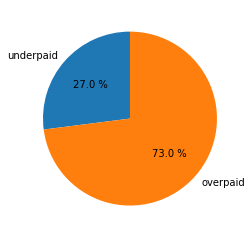

In [56]:
plt.axes(aspect=1)
plt.pie(x=paid_list, labels=wage_label, autopct='%3.1f %%',
        shadow=False, labeldistance=1.1, startangle = 90,pctdistance = 0.6)
plt.show()

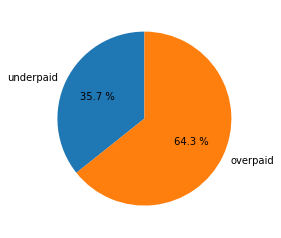

In [57]:
plt.axes(aspect=1)
plt.pie(x=paid_list_high, labels=wage_label, autopct='%3.1f %%',
        shadow=False, labeldistance=1.1, startangle = 90,pctdistance = 0.6)
plt.show()

#### Rating estimation

In [58]:
goalkeeper_attributes = ['Acceleration', 'Aggression', 'Agility', 'Balance', 'BallControl',
       'Body Type', 'Composure', 'Crossing', 'Curve', 'Dribbling', 'FKAccuracy',
       'Finishing', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning',
       'GKReflexes', 'HeadingAccuracy', 'Interceptions','Jumping', 'LongPassing', 'LongShots', 'Marking', 'Penalties',
       'Positioning', 'Reactions', 'ShortPassing', 'ShotPower', 'Skill Moves', 'SlidingTackle',
       'SprintSpeed', 'Stamina', 'StandingTackle', 'Strength', 'Vision', 'Volleys']

In [59]:
attacker = fifa19_noGK[fifa19_noGK["Pref_Pos_String"]=="Attack"]
midfieldr = fifa19_noGK[fifa19_noGK["Pref_Pos_String"]=="Midfield"]
defenser = fifa19_noGK[fifa19_noGK["Pref_Pos_String"]=="Defense"]
goalkeeper = fifa19[fifa19["Position"]=="GK"]
fifa19_CPR_attacker = fifa19_CPR[fifa19_CPR["Pref_Pos_String"]=="Attack"]
fifa19_CPR_midfieldr = fifa19_CPR[fifa19_CPR["Pref_Pos_String"]=="Midfield"]
fifa19_CPR_defenser = fifa19_CPR[fifa19_CPR["Pref_Pos_String"]=="Defense"]
goalkeeper['CPR'] = fifa19["Nationality"].apply(find_CPR)
fifa19_CPR_goalkeeper = goalkeeper[goalkeeper["CPR"] == True]
del goalkeeper["CPR"]
del fifa19_CPR_goalkeeper["CPR"]

attacker_train = attacker[attributes].values
attacker_label = attacker["Overall"].values
midfieldr_train = midfieldr[attributes].values
midfieldr_label = midfieldr["Overall"].values
defenser_train = defenser[attributes].values
defenser_label = defenser["Overall"].values
goalkeeper_train = goalkeeper[goalkeeper_attributes].values
goalkeeper_label = goalkeeper["Overall"].values

scaler = StandardScaler()
scaler.fit(attacker_train)
attacker_scaled = scaler.transform(attacker_train)
CPR_attacker_scaled = scaler.transform(fifa19_CPR_attacker[attributes].values)
scaler = StandardScaler()
scaler.fit(defenser_train)
defenser_scaled = scaler.transform(defenser_train)
CPR_defenser_scaled = scaler.transform(fifa19_CPR_defenser[attributes].values)
scaler = StandardScaler()
scaler.fit(midfieldr_train)
midfieldr_scaled = scaler.transform(midfieldr_train)
CPR_midfieldr_scaled = scaler.transform(fifa19_CPR_midfieldr[attributes].values)
scaler = StandardScaler()
scaler.fit(goalkeeper_train)
goalkeeper_scaled = scaler.transform(goalkeeper_train)
CPR_goalkeeper_scaled = scaler.transform(fifa19_CPR_goalkeeper[goalkeeper_attributes].values)

c:\programdata\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [60]:
attacker_train, attacker_test, attacker_train_label, attacker_test_label = train_test_split(attacker_scaled, attacker_label, test_size=0.25)
midfieldr_train, midfieldr_test, midfieldr_train_label, midfieldr_test_label = train_test_split(midfieldr_scaled, midfieldr_label, test_size=0.25)
defenser_train, defenser_test, defenser_train_label, defenser_test_label = train_test_split(defenser_scaled, defenser_label, test_size=0.25)
goalkeeper_train, goalkeeper_test, goalkeeper_train_label, goalkeeper_test_label = train_test_split(goalkeeper_scaled, goalkeeper_label, test_size=0.25)


In [61]:
def rating_model(input_shape):
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_dim=input_shape, kernel_initializer='TruncatedNormal',kernel_regularizer=l2(1e-4)))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=64, activation='relu', kernel_initializer='TruncatedNormal',kernel_regularizer=l2(1e-4)))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=1, activation=None))
    return model

In [62]:
attacker_rating = rating_model(attacker_train.shape[1])
attacker_rating.compile(optimizer='adam', loss='mean_squared_error', metrics=["mae"])
attacker_rating.fit(attacker_train, attacker_train_label, batch_size=32, epochs=300)

Epoch 1/300
2340/2340 [==============================] - 0s 141us/step - loss: 3614.3029 - mean_absolute_error: 59.2700
Epoch 2/300
2340/2340 [==============================] - 0s 30us/step - loss: 995.2534 - mean_absolute_error: 27.3553
Epoch 3/300
2340/2340 [==============================] - 0s 30us/step - loss: 515.8517 - mean_absolute_error: 18.9651
Epoch 4/300
2340/2340 [==============================] - 0s 30us/step - loss: 352.8792 - mean_absolute_error: 15.3914
Epoch 5/300
2340/2340 [==============================] - 0s 33us/step - loss: 282.4243 - mean_absolute_error: 13.6469
Epoch 6/300
2340/2340 [==============================] - 0s 26us/step - loss: 220.3165 - mean_absolute_error: 11.9738
Epoch 7/300
2340/2340 [==============================] - 0s 30us/step - loss: 175.7291 - mean_absolute_error: 10.7282
Epoch 8/300
2340/2340 [==============================] - 0s 30us/step - loss: 135.6682 - mean_absolute_error: 9.3544
Epoch 9/300
2340/2340 [==============================] 

2340/2340 [==============================] - 0s 28us/step - loss: 32.9135 - mean_absolute_error: 4.5284
Epoch 140/300
2340/2340 [==============================] - 0s 30us/step - loss: 33.4190 - mean_absolute_error: 4.6642
Epoch 141/300
2340/2340 [==============================] - 0s 26us/step - loss: 33.3936 - mean_absolute_error: 4.5614
Epoch 142/300
2340/2340 [==============================] - 0s 30us/step - loss: 33.0376 - mean_absolute_error: 4.5261
Epoch 143/300
2340/2340 [==============================] - 0s 26us/step - loss: 33.1120 - mean_absolute_error: 4.5420
Epoch 144/300
2340/2340 [==============================] - 0s 26us/step - loss: 30.7942 - mean_absolute_error: 4.4063
Epoch 145/300
2340/2340 [==============================] - 0s 30us/step - loss: 33.0408 - mean_absolute_error: 4.5899
Epoch 146/300
2340/2340 [==============================] - 0s 26us/step - loss: 31.7109 - mean_absolute_error: 4.4475
Epoch 147/300
2340/2340 [==============================] - 0s 26us/ste

2340/2340 [==============================] - 0s 30us/step - loss: 23.9497 - mean_absolute_error: 3.8736
Epoch 278/300
2340/2340 [==============================] - 0s 30us/step - loss: 24.3943 - mean_absolute_error: 3.9363
Epoch 279/300
2340/2340 [==============================] - 0s 26us/step - loss: 25.6656 - mean_absolute_error: 3.9890
Epoch 280/300
2340/2340 [==============================] - 0s 30us/step - loss: 24.2571 - mean_absolute_error: 3.9170
Epoch 281/300
2340/2340 [==============================] - 0s 30us/step - loss: 23.4627 - mean_absolute_error: 3.8599
Epoch 282/300
2340/2340 [==============================] - 0s 26us/step - loss: 25.4739 - mean_absolute_error: 4.0081
Epoch 283/300
2340/2340 [==============================] - 0s 30us/step - loss: 25.3742 - mean_absolute_error: 3.9928
Epoch 284/300
2340/2340 [==============================] - 0s 26us/step - loss: 24.9478 - mean_absolute_error: 3.9656
Epoch 285/300
2340/2340 [==============================] - 0s 26us/ste

In [63]:
score, acc = attacker_rating.evaluate(attacker_test, attacker_test_label, batch_size=64)
print(score)

781/781 [==============================] - 0s 82us/step
1.045400863725611


In [64]:
midfieldr_rating = rating_model(midfieldr_train.shape[1])
midfieldr_rating.compile(optimizer='adam', loss='mean_squared_error', metrics=["mae"])
midfieldr_rating.fit(midfieldr_train, midfieldr_train_label, batch_size=32, epochs=300)

Epoch 1/300
4707/4707 [==============================] - 0s 88us/step - loss: 2147.5853 - mean_absolute_error: 40.9423
Epoch 2/300
4707/4707 [==============================] - 0s 30us/step - loss: 417.8983 - mean_absolute_error: 16.7900
Epoch 3/300
4707/4707 [==============================] - 0s 30us/step - loss: 246.4719 - mean_absolute_error: 12.6510
Epoch 4/300
4707/4707 [==============================] - 0s 30us/step - loss: 145.1711 - mean_absolute_error: 9.6955
Epoch 5/300
4707/4707 [==============================] - 0s 30us/step - loss: 106.2341 - mean_absolute_error: 8.2605
Epoch 6/300
4707/4707 [==============================] - 0s 30us/step - loss: 76.1453 - mean_absolute_error: 6.9698
Epoch 7/300
4707/4707 [==============================] - 0s 30us/step - loss: 64.3105 - mean_absolute_error: 6.3870
Epoch 8/300
4707/4707 [==============================] - 0s 32us/step - loss: 59.8853 - mean_absolute_error: 6.1824
Epoch 9/300
4707/4707 [==============================] - 0s 30u

4707/4707 [==============================] - 0s 28us/step - loss: 34.6497 - mean_absolute_error: 4.6671
Epoch 72/300
4707/4707 [==============================] - 0s 28us/step - loss: 33.5103 - mean_absolute_error: 4.6013
Epoch 73/300
4707/4707 [==============================] - 0s 28us/step - loss: 34.4097 - mean_absolute_error: 4.6357
Epoch 74/300
4707/4707 [==============================] - 0s 28us/step - loss: 35.2488 - mean_absolute_error: 4.7258
Epoch 75/300
4707/4707 [==============================] - 0s 30us/step - loss: 34.3198 - mean_absolute_error: 4.6428
Epoch 76/300
4707/4707 [==============================] - 0s 28us/step - loss: 33.4773 - mean_absolute_error: 4.5914
Epoch 77/300
4707/4707 [==============================] - 0s 27us/step - loss: 31.8994 - mean_absolute_error: 4.4594
Epoch 78/300
4707/4707 [==============================] - 0s 28us/step - loss: 32.3616 - mean_absolute_error: 4.4955
Epoch 79/300
4707/4707 [==============================] - 0s 28us/step - loss

4707/4707 [==============================] - 0s 28us/step - loss: 23.6438 - mean_absolute_error: 3.8337
Epoch 210/300
4707/4707 [==============================] - 0s 28us/step - loss: 22.6687 - mean_absolute_error: 3.7917
Epoch 211/300
4707/4707 [==============================] - 0s 29us/step - loss: 22.7961 - mean_absolute_error: 3.7973
Epoch 212/300
4707/4707 [==============================] - 0s 28us/step - loss: 23.1163 - mean_absolute_error: 3.7853
Epoch 213/300
4707/4707 [==============================] - 0s 28us/step - loss: 22.0594 - mean_absolute_error: 3.7126
Epoch 214/300
4707/4707 [==============================] - 0s 30us/step - loss: 22.6540 - mean_absolute_error: 3.7587
Epoch 215/300
4707/4707 [==============================] - 0s 28us/step - loss: 23.4527 - mean_absolute_error: 3.8623
Epoch 216/300
4707/4707 [==============================] - 0s 28us/step - loss: 23.2706 - mean_absolute_error: 3.8132
Epoch 217/300
4707/4707 [==============================] - 0s 28us/ste

In [65]:
score, acc = midfieldr_rating.evaluate(midfieldr_test, midfieldr_test_label, batch_size=64)
print(score)

1569/1569 [==============================] - 0s 46us/step
2.032719003082917


In [66]:
defenser_rating = rating_model(defenser_train.shape[1])
defenser_rating.compile(optimizer='adam', loss='mean_squared_error', metrics=["mae"])
defenser_rating.fit(defenser_train, defenser_train_label, batch_size=32, epochs=300)

Epoch 1/300
4051/4051 [==============================] - 0s 105us/step - loss: 2475.8686 - mean_absolute_error: 45.5608
Epoch 2/300
4051/4051 [==============================] - 0s 32us/step - loss: 485.5586 - mean_absolute_error: 18.1948
Epoch 3/300
4051/4051 [==============================] - 0s 30us/step - loss: 284.9630 - mean_absolute_error: 13.7118
Epoch 4/300
4051/4051 [==============================] - 0s 32us/step - loss: 189.2560 - mean_absolute_error: 11.1074
Epoch 5/300
4051/4051 [==============================] - 0s 30us/step - loss: 144.7159 - mean_absolute_error: 9.5541
Epoch 6/300
4051/4051 [==============================] - 0s 30us/step - loss: 111.1633 - mean_absolute_error: 8.3530
Epoch 7/300
4051/4051 [==============================] - 0s 31us/step - loss: 98.8699 - mean_absolute_error: 7.9516
Epoch 8/300
4051/4051 [==============================] - 0s 33us/step - loss: 83.2660 - mean_absolute_error: 7.2626
Epoch 9/300
4051/4051 [==============================] - 0s 

Epoch 71/300
4051/4051 [==============================] - 0s 35us/step - loss: 43.0611 - mean_absolute_error: 5.2027
Epoch 72/300
4051/4051 [==============================] - 0s 35us/step - loss: 43.0220 - mean_absolute_error: 5.2346
Epoch 73/300
4051/4051 [==============================] - 0s 32us/step - loss: 42.5515 - mean_absolute_error: 5.2012
Epoch 74/300
4051/4051 [==============================] - 0s 35us/step - loss: 43.8985 - mean_absolute_error: 5.2568
Epoch 75/300
4051/4051 [==============================] - 0s 33us/step - loss: 39.7184 - mean_absolute_error: 5.0326
Epoch 76/300
4051/4051 [==============================] - 0s 32us/step - loss: 40.7788 - mean_absolute_error: 5.0853
Epoch 77/300
4051/4051 [==============================] - 0s 32us/step - loss: 40.0080 - mean_absolute_error: 5.0315
Epoch 78/300
4051/4051 [==============================] - 0s 35us/step - loss: 39.7617 - mean_absolute_error: 5.0025
Epoch 79/300
4051/4051 [==============================] - 0s 32u

4051/4051 [==============================] - 0s 32us/step - loss: 26.3047 - mean_absolute_error: 4.0749
Epoch 210/300
4051/4051 [==============================] - 0s 34us/step - loss: 26.2992 - mean_absolute_error: 4.0737
Epoch 211/300
4051/4051 [==============================] - 0s 35us/step - loss: 27.5560 - mean_absolute_error: 4.1339
Epoch 212/300
4051/4051 [==============================] - 0s 32us/step - loss: 25.8952 - mean_absolute_error: 4.0729
Epoch 213/300
4051/4051 [==============================] - 0s 32us/step - loss: 26.2389 - mean_absolute_error: 4.0424
Epoch 214/300
4051/4051 [==============================] - 0s 35us/step - loss: 27.8467 - mean_absolute_error: 4.2090
Epoch 215/300
4051/4051 [==============================] - 0s 32us/step - loss: 26.6388 - mean_absolute_error: 4.0925
Epoch 216/300
4051/4051 [==============================] - 0s 32us/step - loss: 25.5302 - mean_absolute_error: 3.9797
Epoch 217/300
4051/4051 [==============================] - 0s 32us/ste

In [67]:
score, acc = defenser_rating.evaluate(defenser_test, defenser_test_label, batch_size=64)
print(score)

1351/1351 [==============================] - 0s 61us/step
1.8984036502089878


In [68]:
goalkeeper_rating = rating_model(goalkeeper_train.shape[1])
goalkeeper_rating.compile(optimizer='adam', loss='mean_squared_error', metrics=["mae"])
goalkeeper_rating.fit(goalkeeper_train, goalkeeper_train_label, batch_size=32, epochs=300)

Epoch 1/300
1473/1473 [==============================] - 0s 258us/step - loss: 4138.3650 - mean_absolute_error: 63.9201
Epoch 2/300
1473/1473 [==============================] - 0s 34us/step - loss: 2606.1829 - mean_absolute_error: 48.9104
Epoch 3/300
1473/1473 [==============================] - 0s 27us/step - loss: 1034.9139 - mean_absolute_error: 27.7104
Epoch 4/300
1473/1473 [==============================] - 0s 27us/step - loss: 737.8465 - mean_absolute_error: 22.7699
Epoch 5/300
1473/1473 [==============================] - 0s 34us/step - loss: 576.6131 - mean_absolute_error: 19.8063
Epoch 6/300
1473/1473 [==============================] - 0s 27us/step - loss: 430.6067 - mean_absolute_error: 16.9563
Epoch 7/300
1473/1473 [==============================] - 0s 34us/step - loss: 365.2544 - mean_absolute_error: 15.2956
Epoch 8/300
1473/1473 [==============================] - 0s 34us/step - loss: 298.7010 - mean_absolute_error: 13.8487
Epoch 9/300
1473/1473 [=============================

1473/1473 [==============================] - 0s 34us/step - loss: 53.1685 - mean_absolute_error: 5.8492
Epoch 140/300
1473/1473 [==============================] - 0s 27us/step - loss: 52.9058 - mean_absolute_error: 5.7546
Epoch 141/300
1473/1473 [==============================] - 0s 27us/step - loss: 51.0607 - mean_absolute_error: 5.5780
Epoch 142/300
1473/1473 [==============================] - 0s 34us/step - loss: 55.2276 - mean_absolute_error: 5.9724
Epoch 143/300
1473/1473 [==============================] - 0s 27us/step - loss: 51.0950 - mean_absolute_error: 5.6510
Epoch 144/300
1473/1473 [==============================] - 0s 34us/step - loss: 58.5574 - mean_absolute_error: 6.0512
Epoch 145/300
1473/1473 [==============================] - 0s 27us/step - loss: 50.5604 - mean_absolute_error: 5.5207
Epoch 146/300
1473/1473 [==============================] - 0s 26us/step - loss: 49.9489 - mean_absolute_error: 5.5852
Epoch 147/300
1473/1473 [==============================] - 0s 34us/ste

1473/1473 [==============================] - 0s 27us/step - loss: 40.4330 - mean_absolute_error: 4.9851
Epoch 278/300
1473/1473 [==============================] - 0s 34us/step - loss: 41.1280 - mean_absolute_error: 5.0131
Epoch 279/300
1473/1473 [==============================] - 0s 27us/step - loss: 41.4371 - mean_absolute_error: 5.0895
Epoch 280/300
1473/1473 [==============================] - 0s 27us/step - loss: 41.9495 - mean_absolute_error: 5.1162
Epoch 281/300
1473/1473 [==============================] - 0s 27us/step - loss: 43.0923 - mean_absolute_error: 5.1578
Epoch 282/300
1473/1473 [==============================] - 0s 27us/step - loss: 39.7722 - mean_absolute_error: 5.0258
Epoch 283/300
1473/1473 [==============================] - 0s 34us/step - loss: 41.3768 - mean_absolute_error: 5.0589
Epoch 284/300
1473/1473 [==============================] - 0s 27us/step - loss: 38.5336 - mean_absolute_error: 4.8649
Epoch 285/300
1473/1473 [==============================] - 0s 27us/ste

In [69]:
score, acc = goalkeeper_rating.evaluate(goalkeeper_test, goalkeeper_test_label, batch_size=64)
print(score)

491/491 [==============================] - 0s 194us/step
1.4211015567760117


In [70]:

attacker_pred = attacker_rating.predict(CPR_attacker_scaled)
fifa19_CPR_attacker["predicted overall"] = attacker_pred
midfieldr_pred = midfieldr_rating.predict(CPR_midfieldr_scaled)
fifa19_CPR_midfieldr["predicted overall"] = midfieldr_pred
defenser_pred = defenser_rating.predict(CPR_defenser_scaled)
fifa19_CPR_defenser["predicted overall"] = defenser_pred
goalkeeper_pred = goalkeeper_rating.predict(CPR_goalkeeper_scaled)
fifa19_CPR_goalkeeper["predicted overall"] = goalkeeper_pred

In [71]:
fifa19_CPR_attacker

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,StandingTackle,Strength,Vision,Volleys,Weak Foot,Work Rate,Pref_Pos_Encoded,Pref_Pos_String,wage difference,predicted overall
3383,182043,Zeng Cheng,31,https://cdn.sofifa.org/players/4/19/182043.png,China PR,https://cdn.sofifa.org/flags/155.png,72,72,Guangzhou Evergrande Taobao FC,https://cdn.sofifa.org/teams/2/light/111839.png,...,28,73,51,64,3,High/ Medium,1,Attack,214.699219,70.846176
3562,224599,Yan Junling,27,https://cdn.sofifa.org/players/4/19/224599.png,China PR,https://cdn.sofifa.org/flags/155.png,72,74,Shanghai SIPG FC,https://cdn.sofifa.org/teams/2/light/112540.png,...,40,72,60,69,3,Medium/ Medium,1,Attack,-4422.293945,71.750580
3579,241247,Su Boyang,29,https://cdn.sofifa.org/players/4/19/241247.png,China PR,https://cdn.sofifa.org/flags/155.png,72,73,Guizhou Hengfeng FC,https://cdn.sofifa.org/teams/2/light/112977.png,...,28,68,69,67,4,Medium/ Medium,1,Attack,-10154.277344,72.478714
3671,221820,Zhang Xizhe,27,https://cdn.sofifa.org/players/4/19/221820.png,China PR,https://cdn.sofifa.org/flags/155.png,72,72,Beijing Sinobo Guoan FC,https://cdn.sofifa.org/teams/2/light/111768.png,...,21,76,63,69,3,Medium/ Low,1,Attack,2737.222656,71.277023
5268,223344,Wei Shihao,23,https://cdn.sofifa.org/players/4/19/223344.png,China PR,https://cdn.sofifa.org/flags/155.png,70,75,Beijing Sinobo Guoan FC,https://cdn.sofifa.org/teams/2/light/111768.png,...,14,92,49,69,3,High/ Medium,1,Attack,-2285.605469,69.555099
5999,217153,Wu Xi,29,https://cdn.sofifa.org/players/4/19/217153.png,China PR,https://cdn.sofifa.org/flags/155.png,69,69,Jiangsu Suning FC,https://cdn.sofifa.org/teams/2/light/112162.png,...,38,58,64,49,4,Medium/ High,1,Attack,3748.220703,66.975136
7001,201026,Yi Teng,28,https://cdn.sofifa.org/players/4/19/201026.png,China PR,https://cdn.sofifa.org/flags/155.png,68,69,Guangzhou R&F FC,https://cdn.sofifa.org/teams/2/light/112429.png,...,37,62,65,65,4,Medium/ Medium,1,Attack,-2026.228027,68.325195
7163,202855,Tan Long,30,https://cdn.sofifa.org/players/4/19/202855.png,China PR,https://cdn.sofifa.org/flags/155.png,68,68,Changchun Yatai FC,https://cdn.sofifa.org/teams/2/light/111769.png,...,35,68,64,66,2,Medium/ Medium,1,Attack,-476.764648,68.434830
7395,221855,Liu Binbin,25,https://cdn.sofifa.org/players/4/19/221855.png,China PR,https://cdn.sofifa.org/flags/155.png,68,70,Shandong Luneng TaiShan FC,https://cdn.sofifa.org/teams/2/light/111724.png,...,23,71,61,58,3,Medium/ Medium,1,Attack,-371.516113,68.197243
8141,182096,Zheng Long,30,https://cdn.sofifa.org/players/4/19/182096.png,China PR,https://cdn.sofifa.org/flags/155.png,67,67,Guangzhou Evergrande Taobao FC,https://cdn.sofifa.org/teams/2/light/111839.png,...,32,57,59,59,3,High/ Medium,1,Attack,2360.723633,66.455177


We can find that the model can predict the score prefectly!